# Optimized XGBoost Image Classification
This notebook performs image classification using XGBoost with PCA-reduced features.

In [7]:
import os
import cv2  # type: ignore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

IMG_SIZE = (64, 64)  # Resize images 

TRAIN_LIST_PATH = "train.txt"
TEST_LIST_PATH = "val.txt"

def load_images_and_extract_features(file_list_path):
    X = []  
    y = []  
    class_labels = {}  
    label_counter = 0  

    with open(file_list_path, "r") as file:
        image_paths = file.read().splitlines()

    for img_path in image_paths:
        img_path = img_path.strip()
        if not os.path.exists(img_path):
            continue  

        
        class_name = os.path.dirname(img_path).split(os.sep)[-1]

        
        if class_name not in class_labels:
            class_labels[class_name] = label_counter
            label_counter += 1

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue  

        
        img = cv2.resize(img, IMG_SIZE)

        
        pixel_features = img.flatten()

        # Extract color histogram features
        hist_features = []
        for i in range(3):  # RGB channels
            hist = cv2.calcHist([img], [i], None, [256], [0, 256]).flatten()
            hist_features.extend(hist)

        # Combine features
        features = np.hstack([pixel_features, hist_features])

        # Append to dataset
        X.append(features)
        y.append(class_labels[class_name])  

    return np.array(X), np.array(y), class_labels


## Load Training and Testing Datasets

In [9]:

X_train, y_train, class_labels_train = load_images_and_extract_features(TRAIN_LIST_PATH)
X_test, y_test, class_labels_test = load_images_and_extract_features(TEST_LIST_PATH)
    

## Normalize Features

In [9]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Set: {len(y_train)} images across {len(class_labels_train)} classes")
print(f"Testing Set: {len(y_test)} images across {len(class_labels_test)} classes")
print(f"Feature vector shape (training): {X_train_scaled.shape}")
print(f"Feature vector shape (testing): {X_test_scaled.shape}")
    

Training Set: 10000 images across 3 classes
Testing Set: 200 images across 3 classes
Feature vector shape (training): (10000, 13056)
Feature vector shape (testing): (200, 13056)


## Reduce Feature Dimensions Using PCA

In [10]:

pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
    

## Train XGBoost Classifier

In [11]:

xgb_classifier = xgb.XGBClassifier(
    n_estimators=50,        # Reduce boosting rounds
    max_depth=4,            # Reduce tree depth
    learning_rate=0.1,      # Keep same learning rate
    objective='multi:softmax', 
    num_class=3,            
    eval_metric='mlogloss',
    n_jobs=-1           
)

# Train the model
print("Training Optimized XGBoost model...")
xgb_classifier.fit(X_train_pca, y_train)
    

Training Optimized XGBoost model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=-1, num_class=3, num_parallel_tree=None, ...)

## Make Predictions and Evaluate Performance

In [12]:

y_pred = xgb_classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))
    


Model Accuracy: 0.8350

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.86      0.80      0.83       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200



## Plot Confusion Matrix

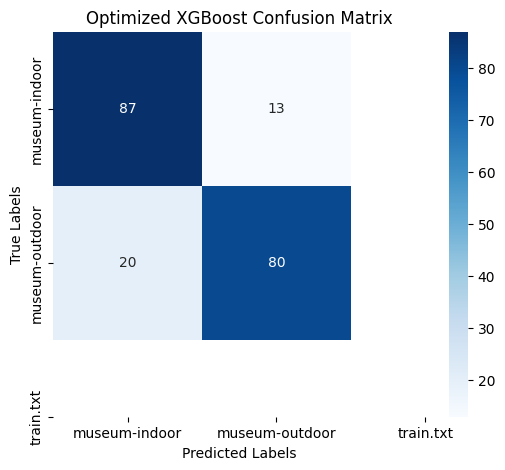

In [13]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels_train, yticklabels=class_labels_train)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Optimized XGBoost Confusion Matrix")
plt.show()
    